In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, MultiPoint, MultiLineString, Polygon, MultiPolygon
from shapely.ops import cascaded_union, linemerge, nearest_points
from centerline.geometry import Centerline

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import contextily as cx

from statistics import mean

import osmnx as ox
import networkx as nx

In [2]:
from ctwalk import places, widths, streets

# CTwalk library examples
Vasilis Milias & Roos Teeuwen, 2023

## Set parameters

In [3]:
style.use('default')
folder = 'data'
osm_crs = 'EPSG:3857'

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006

place_name = 'Centrum, Amsterdam'
local_crs = 'EPSG:28992'
buffer = 800

In [5]:
landuse_filename = 'BGT_all_roads_Amsterdam.shp'
landuse_sidewalk_filters = {'function': ['voetpad', 'voetgangersgebied', 'voetpad op trap', 'woonerf']}
landuse_bikepath_filters = {'function': ['fietspad']}

## Load data: pedestrian and bike networks, high-granularity land use data

In [6]:
# get all walkable streets for the place and its surroundings
walk_street_dict = streets.get_streets_per_cities(
    cities=[place_name], buffer_dist=buffer, network_type='walk', 
    intersection_clos=False,  street_betw=False, street_sin=False, retain_all=True, 
    return_raw_data=True)

# unpack collected graph, and its edges and nodes as a geodataframe
walk_graph = walk_street_dict[place_name]['graph']
walk_edges = walk_street_dict[place_name]['edges']
walk_nodes = walk_street_dict[place_name]['nodes']

Centrum, Amsterdam


In [7]:
# get all walkable streets for the place and its surroundings
bike_street_dict = streets.get_streets_per_cities(
    cities=[place_name], buffer_dist=buffer, network_type='bike', 
    intersection_clos=False,  street_betw=False, street_sin=False, retain_all=True, 
    return_raw_data=True)

# unpack collected graph, and its edges and nodes as a geodataframe
bike_graph = bike_street_dict[place_name]['graph']
bike_edges = bike_street_dict[place_name]['edges']
bike_nodes = bike_street_dict[place_name]['nodes']

Centrum, Amsterdam


In [8]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

In [9]:
# load your local high-granularity land use data set
# (i.e., with polygons depicting sidewalks, bike paths, etc.)
area_of_interest = place.convex_hull.geometry
landuse = gpd.read_file(os.path.join(folder, landuse_filename), mask=area_of_interest)

## Enrich

#### Centrality and sinuosity measures for pedestrian infrastructure

In [10]:
# node closeness
walk_enriched_nodes = streets.compute_node_closeness(walk_graph, weight='length')

Convert to igraph ...
Calculating closeness ...
Convert to dataframe closeness ...


In [11]:
# edge betweenness
walk_enriched_edges = streets.compute_edge_betweenness(walk_graph, weight='length')

Convert to igraph ...
Calculating betweenness ...
Convert to dataframe betweenness ...


In [12]:
# edge sinuosity
walk_enriched_edges = streets.compute_edge_sinuosity(walk_enriched_edges)

#### Width measures for pedestrian infrastructure

In [13]:
# filter out infrastructure for pedestrians: sidewalks
# calculate widths of sidewalks
sidewalks = gpd.GeoDataFrame()
for col in landuse_sidewalk_filters.keys():
    sidewalk_landuse = landuse[landuse[col].isin(landuse_sidewalk_filters[col])]
    sidewalks = pd.concat([sidewalks, sidewalk_landuse])
sidewalks_with_widths = widths.get_polygon_width(sidewalks)

skipping one row because of error making centerline
skipping one row because of error making centerline
skipping one row because of error making centerline
skipping one row because of error making centerline
skipping one row because of error making centerline
skipping one row because of error making centerline
skipping one row because of error making centerline


In [14]:
# and store average sidewalk width per street segment
# ensure land use data is in the same CRS as your streets
# this CRS should use meters, not lat lon
walk_enriched_edges = walk_enriched_edges.to_crs(landuse.crs)
walk_enriched_edges = streets.compute_edge_average_polygon_width(walk_enriched_edges, sidewalks_with_widths, output_col='average_sidewalk_width')

/Users/roosteeuwen/opt/anaconda3/envs/equallife/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  """


##### Width measures for bicycle infrastructure

In [15]:
# filter out infrastructure for bikes: bike paths
# calculate widths of bike paths
bikepaths = gpd.GeoDataFrame()
for col in landuse_bikepath_filters.keys():
    bikepath_landuse = landuse[landuse[col].isin(landuse_bikepath_filters[col])]
    bikepaths = pd.concat([bikepaths, bikepath_landuse])
bikepaths_with_widths = widths.get_polygon_width(bikepaths)

In [16]:
# and store average sidewalk width per street segment
# ensure land use data is in the same CRS as your streets
# this CRS should use meters, not lat lon
bike_enriched_edges = bike_edges.to_crs(landuse.crs)
bike_enriched_edges.reset_index(inplace=True)
bike_enriched_edges = streets.compute_edge_average_polygon_width(bike_enriched_edges, bikepaths_with_widths, output_col='average_bikepath_width')

/Users/roosteeuwen/opt/anaconda3/envs/equallife/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  


## Plot

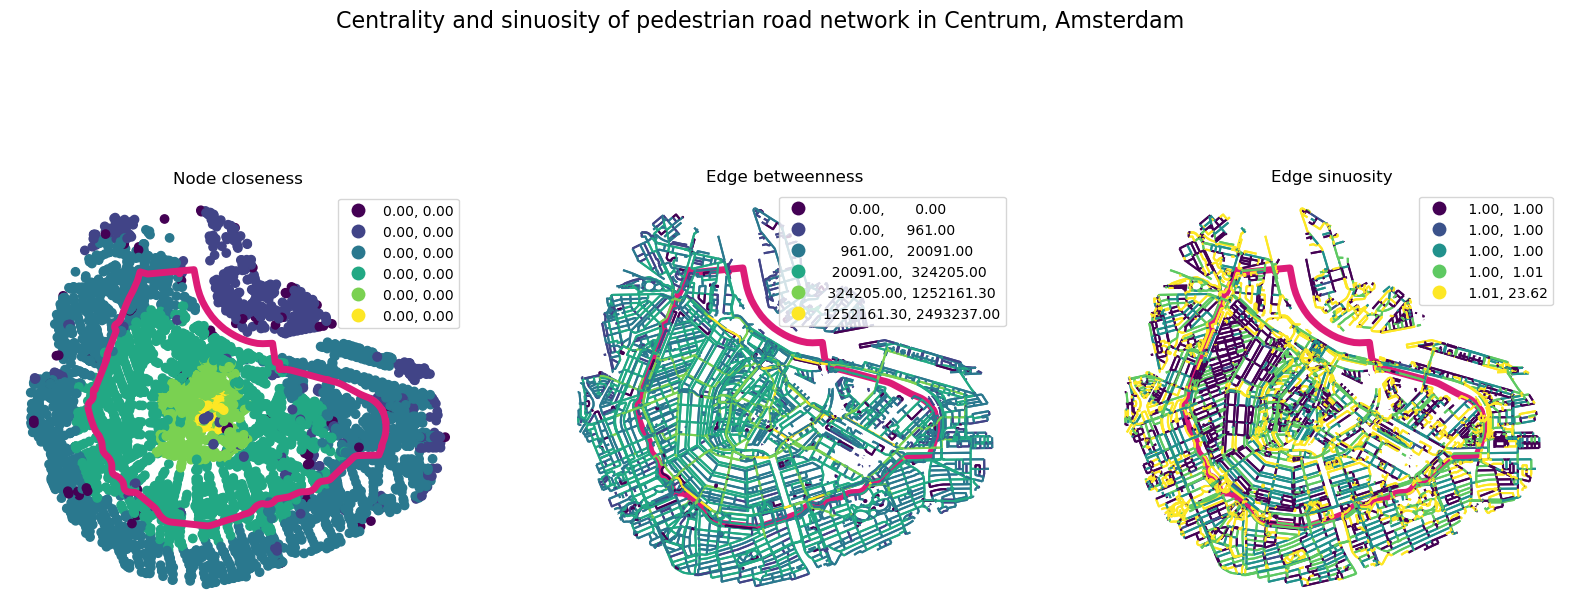

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
fig.suptitle('Centrality and sinuosity of pedestrian road network in {}'.format(place_name), fontsize=16)

# node closeness
walk_enriched_nodes.to_crs(local_crs).plot(ax=axs[0], column='node_closeness', cmap='viridis', scheme='percentiles', legend=True)
axs[0].set_title('Node closeness')

# edge betweenness
walk_enriched_edges.plot(ax=axs[1], column='edge_betweenness', cmap='viridis', scheme='percentiles', legend=True)
axs[1].set_title('Edge betweenness')

# sinuosity
walk_enriched_edges.plot(ax=axs[2], column='edge_sinuosity', cmap='viridis', scheme='quantiles', legend=True)
axs[2].set_title('Edge sinuosity')

for ax in axs:
    place.plot(ax=ax, facecolor='None', edgecolor='#dd1c77', linewidth=5)
    ax.axis('off')

plt.show()

In [18]:
# categorise streets according to width, assign them colors, and create a legend

cmap = cm.get_cmap('viridis', 12)
width_breaks = [1, 2, 3, 4]

walk_enriched_edges.loc[walk_enriched_edges['average_sidewalk_width'] < width_breaks[0], 'width_color'] = 0.0
walk_enriched_edges.loc[(walk_enriched_edges['average_sidewalk_width'] >= width_breaks[0]) & (walk_enriched_edges['average_sidewalk_width'] < width_breaks[1]), 'width_color'] = 0.25
walk_enriched_edges.loc[(walk_enriched_edges['average_sidewalk_width'] >= width_breaks[1]) & (walk_enriched_edges['average_sidewalk_width'] < width_breaks[2]), 'width_color'] = 0.5
walk_enriched_edges.loc[(walk_enriched_edges['average_sidewalk_width'] >= width_breaks[2]) & (walk_enriched_edges['average_sidewalk_width'] < width_breaks[3]), 'width_color'] = 0.75
walk_enriched_edges.loc[walk_enriched_edges['average_sidewalk_width'] >= width_breaks[3], 'width_color'] = 1.0

bike_enriched_edges.loc[bike_enriched_edges['average_bikepath_width'] < width_breaks[0], 'width_color'] = 0.0
bike_enriched_edges.loc[(bike_enriched_edges['average_bikepath_width'] >= width_breaks[0]) & (bike_enriched_edges['average_bikepath_width'] < width_breaks[1]), 'width_color'] = 0.25
bike_enriched_edges.loc[(bike_enriched_edges['average_bikepath_width'] >= width_breaks[1]) & (bike_enriched_edges['average_bikepath_width'] < width_breaks[2]), 'width_color'] = 0.5
bike_enriched_edges.loc[(bike_enriched_edges['average_bikepath_width'] >= width_breaks[2]) & (bike_enriched_edges['average_bikepath_width'] < width_breaks[3]), 'width_color'] = 0.75
bike_enriched_edges.loc[bike_enriched_edges['average_bikepath_width'] >= width_breaks[3], 'width_color'] = 1.0

width_handles = [
    mlines.Line2D([], [], color=cmap(0.0), linestyle='-', linewidth=3, label='0 to {} m wide'.format(width_breaks[0])),
    mlines.Line2D([], [], color=cmap(0.25), linestyle='-', linewidth=3, label='{} to {} m wide'.format(width_breaks[0], width_breaks[1])),
    mlines.Line2D([], [], color=cmap(0.5), linestyle='-', linewidth=3, label='{} to {} m wide'.format(width_breaks[1], width_breaks[2])),
    mlines.Line2D([], [], color=cmap(0.75), linestyle='-', linewidth=3, label='{} to {} m wide'.format(width_breaks[2], width_breaks[3])),
    mlines.Line2D([], [], color=cmap(1.0), linestyle='-', linewidth=3, label='Over {} m wide'.format(width_breaks[3])),
    mlines.Line2D([], [], color='grey', linestyle='-', linewidth=1, label='Unknown'),
    mlines.Line2D([], [], color='None', linestyle='-', linewidth=3, label=''),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')]

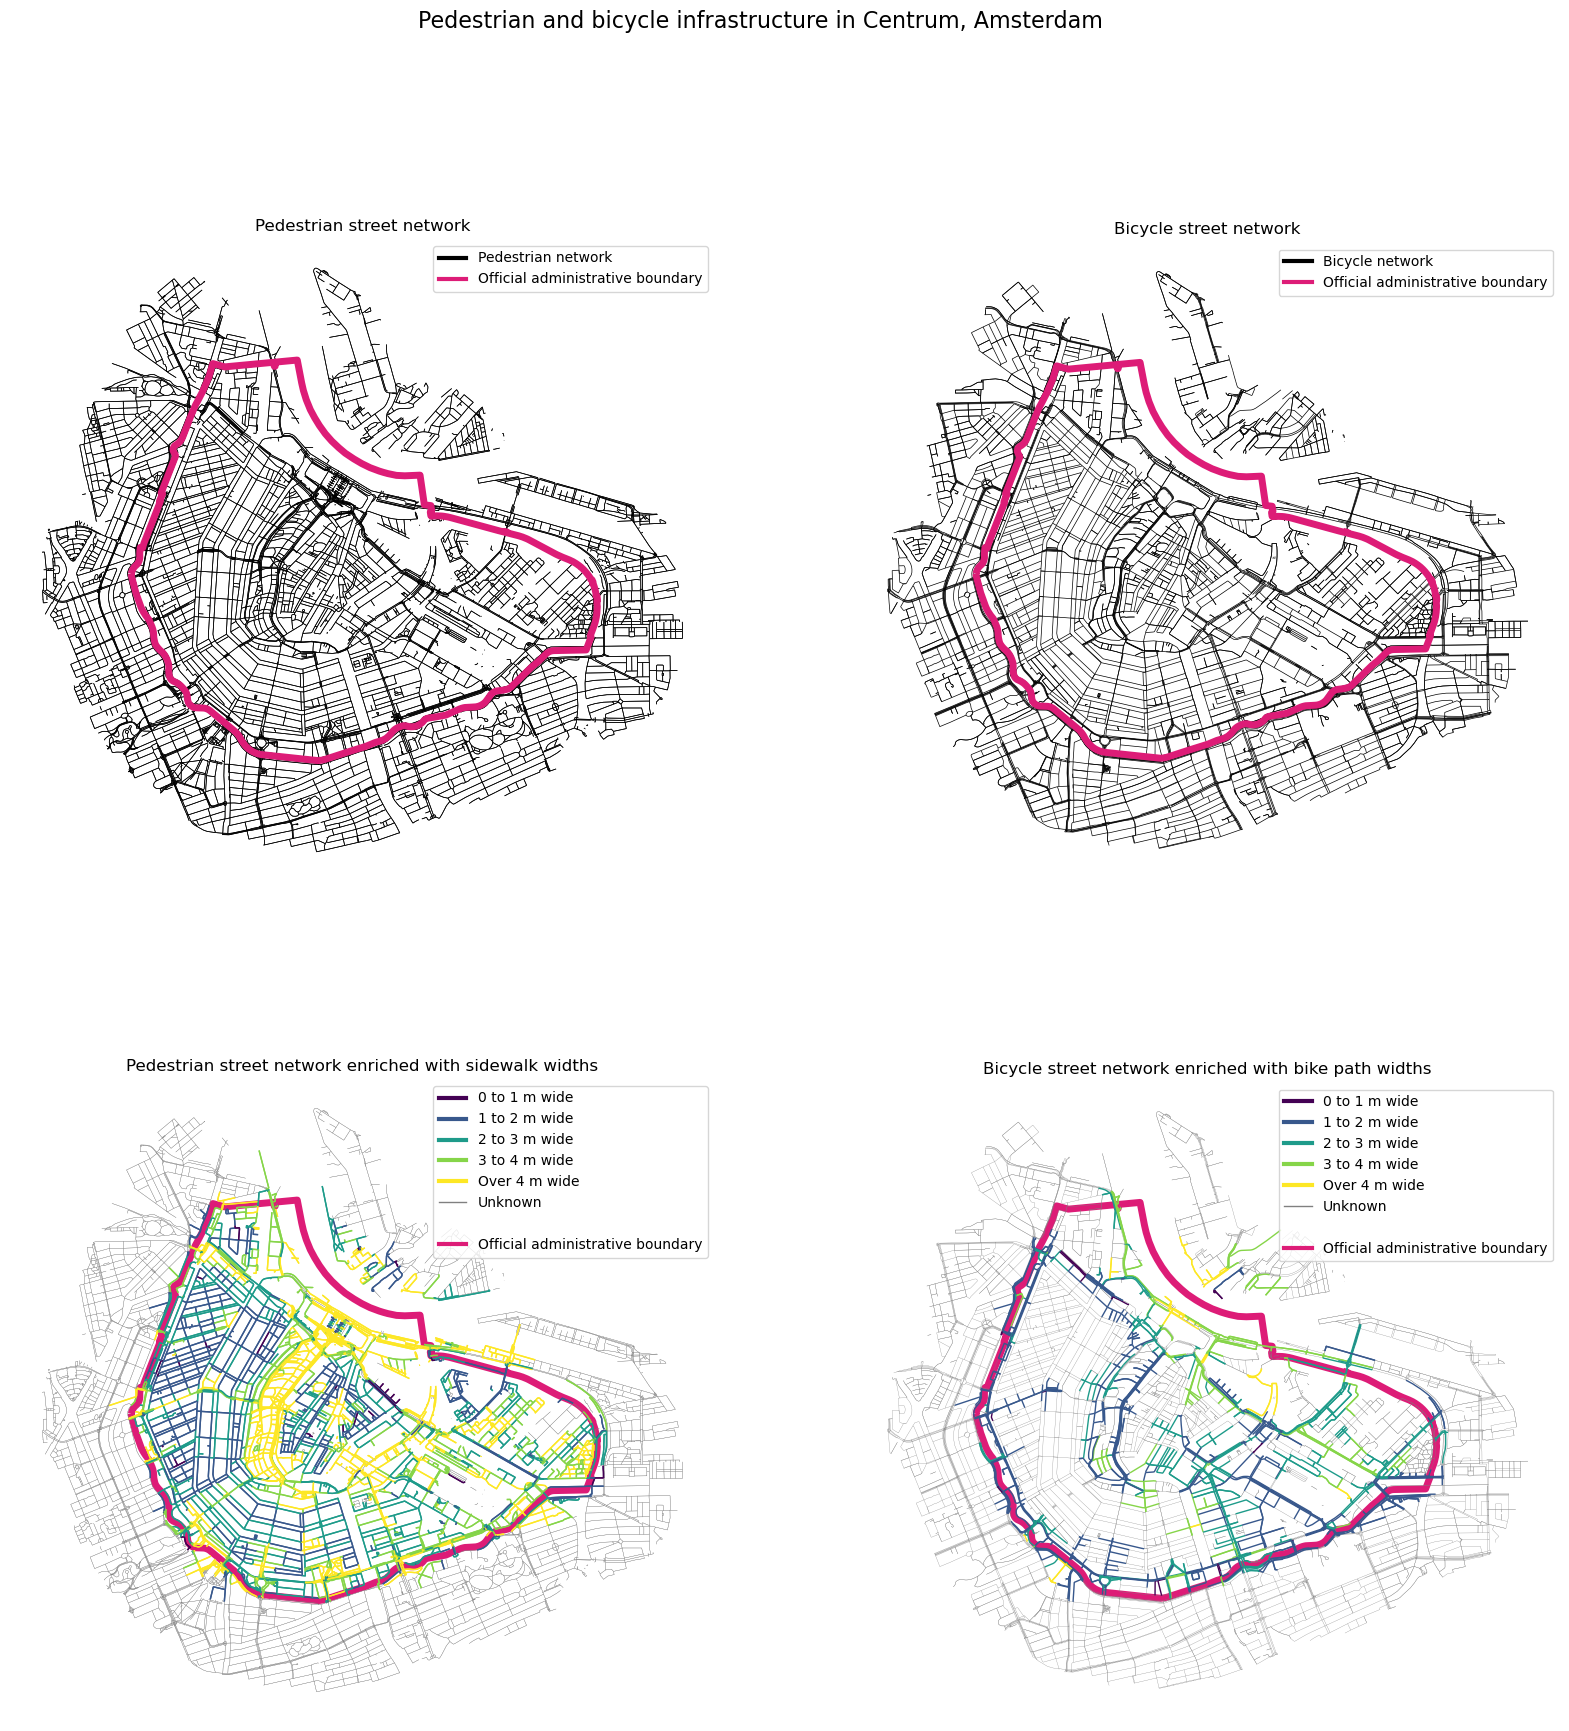

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
fig.suptitle('Pedestrian and bicycle infrastructure in {}'.format(place_name), fontsize=16)

# pedestrian network
walk_enriched_edges.plot(ax=axs[0,0], color='black', linewidth=0.5, zorder=1)
axs[0,0].set_title('Pedestrian street network')
walk_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=3, label='Pedestrian network'),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')]
axs[0,0].legend(handles=walk_handles, loc='upper right')

# bicycle network
bike_enriched_edges.plot(ax=axs[0,1], color='black', linewidth=0.5, zorder=1)
axs[0,1].set_title('Bicycle street network')
bike_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=3, label='Bicycle network'),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')]
axs[0,1].legend(handles=bike_handles, loc='upper right')

# pedestrian network with sidewalk widths
walk_enriched_edges[walk_enriched_edges['average_sidewalk_width'].isna()].plot(ax=axs[1,0], linewidth=0.2, color='grey')
walk_enriched_edges[walk_enriched_edges['average_sidewalk_width'].notna()].plot(ax=axs[1,0], linewidth=1, column='width_color', cmap=cmap)
axs[1,0].set_title('Pedestrian street network enriched with sidewalk widths')
axs[1,0].legend(handles=width_handles, loc='upper right')

# bicycle network with bike path widths
bike_enriched_edges[bike_enriched_edges['average_bikepath_width'].isna()].plot(ax=axs[1,1], linewidth=0.2, color='grey')
bike_enriched_edges[bike_enriched_edges['average_bikepath_width'].notna()].plot(ax=axs[1,1], linewidth=1, column='width_color', cmap=cmap)
axs[1,1].set_title('Bicycle street network enriched with bike path widths')
axs[1,1].legend(handles=width_handles, loc='upper right')

for ax in axs:
    for a in ax:
        place.plot(ax=a, facecolor='None', edgecolor='#dd1c77', linewidth=5)
        a.axis('off')

plt.show()